<a href="https://colab.research.google.com/github/vcskaushik1/Sneeze-Detection/blob/master/Sneeze_Detector_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import os
import math
import random
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras 
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, ZeroPadding3D, BatchNormalization, Activation, Attention
from tensorflow.keras.layers import LSTM, TimeDistributed,Conv2D, MaxPooling3D, Conv3D,MaxPooling2D
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from skimage.io import imread, imread_collection, concatenate_images, ImageCollection
from tensorflow.keras.utils import Sequence

In [0]:
!cp -r drive/"My Drive"/"Adv DL project"/"PGM" ADV_FILES

In [0]:
!unzip drive/"My Drive"/"Adv DL project"/frames.zip -d ADV_FILES/

Streaming output truncated to the last 5000 lines.
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame75.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame20.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame48.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame58.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame8.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame80.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame51.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame5.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame73.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame53.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame16.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame3.jpg  
  inflating: ADV_FILES/frames/S018_M_SNEE_WLK_RGT_frames/frame10.jpg  
  inflating: ADV_FILES/frames

In [0]:
!unzip ADV_FILES/Test_set.zip -d ADV_FILES/"Adv DL project"
!unzip ADV_FILES/Train_set.zip -d ADV_FILES/"Adv DL project"

Streaming output truncated to the last 5000 lines.
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame53.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame65.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame56.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame78.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame55.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame17.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame26.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame18.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame84.jpg  
  inflating: ADV_FILES/Adv DL project/Train_set/S001_M_WIPE_STD_LFT_HF_frames/frame58.jpg  
  inflating: ADV_FILES/Adv DL

In [0]:
train_path ='ADV_FILES/Adv DL project/Train_set/'
test_path ='ADV_FILES/Adv DL project/Test_set/'
label_p ='ADV_FILES/final_data4.json'
model_path = 'drive/My Drive/Adv DL project/model2.hdf5'

In [0]:
df2  = pd.read_json(label_p)

In [0]:
class DataGenerator(Sequence):
  def __init__(self, path,video_list, label_df,to_fit=True, batch_size=5, dim=(290, 480),n_channels=3, n_classes=30, shuffle=True):
    """Parameters
    : video_list: list of all videos
    : labels: list of image labels (file names)
    : path: path to location of videos
    : label_path: path to label json file
    : to_fit: True to return X(batch video frames) and y(labels), False to return X only
    : batch_size: batch size at each iteration
    : dim: tuple indicating image dimension
    : n_channels: number of image channels
    : n_classes: number of output classes also same as time dimension
    : shuffle: True to shuffle label indexes after every epoch
    """
    self.path = path
    self.video_list = video_list
    self.label_df = label_df
    self.to_fit = to_fit
    self.batch_size = batch_size
    self.dim = dim
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()
    
    
  def __len__(self):
    if self.batch_size % 2 == 0:
      return int(np.floor(len(self.video_list) / self.batch_size))
    else:
      return int(np.ceil(len(self.video_list) / self.batch_size))

  def __getitem__(self, index):
    # Generate indexes of the batch
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    # Find list of IDs
    video_list_temp = [self.video_list[k] for k in indexes]

    # Generate data
    X = self._generate_X(video_list_temp)

    if self.to_fit:
      y = self._generate_y(video_list_temp)
      return X, y
    else:
      return X

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.video_list))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def _generate_X(self, video_list_temp):
    # Initialization
    X = np.empty((self.batch_size, self.n_classes,*self.dim, self.n_channels))

    # Generate data
    for i, VID in enumerate(video_list_temp):
        # Store sample
        X[i,:] = self._load_frames(VID)
    return X
  
  def _load_frames(self,vid):
    video_path = self.path + vid
    frame_paths = os.listdir(video_path)
    frame_input1= [imread(video_path+'/'+fr_path)/255 for fr_path in frame_paths]
    if (len(frame_input1) < self.n_classes):
      diff = math.ceil((self.n_classes-len(frame_input1))/2)
      frame_input = [None]*self.n_classes
      # Repeating First element
      frame_input[0:diff] = [frame_input1[0]]*diff
      # Centering frames
      frame_input[diff:diff+len(frame_input1)] = frame_input1
      #Repeating last frames
      frame_input[diff+len(frame_input1):] = [frame_input1[-1]]*(self.n_classes-len(frame_input1)-diff)
    elif (len(frame_input1) > self.n_classes) :
      idx = self.get_labels(vid,need_idx=1)
      frame_input = frame_input1[idx[0]:idx[1]]
    else:
      frame_input = frame_input1
    frame_input = np.array(frame_input)
    if np.sum(np.isnan(frame_input))>0:
      print(np.sum(np.isnan(frame_input)))
    return frame_input


  def _generate_y(self, video_list_temp):
    y = np.empty([self.batch_size, self.n_classes,2],dtype=float)

    # Generate data
    for i, VID in enumerate(video_list_temp):
        # Store sample
        y[i,:] = self.get_labels(VID)

    return y
    
  def get_labels(self,label_file,need_idx=False):
    
    frame_paths = os.listdir(self.path + label_file)
    n_f = len(frame_paths)
    df = self.label_df
    labels = df.loc[label_file].values
    where_are_nans = np.isnan(labels)
    labels[where_are_nans] = 0
    labels = np.squeeze(labels)
    n_l = self.n_classes
    if n_l > n_f :
      diff = math.ceil((n_l-n_f)/2)
      output = [None]*n_l
      # Repeating First element
      output[0:diff] = [labels[0]]*diff
      # Centering frames
      output[diff:diff + n_f] = labels[0:n_f]
      #Repeating last frames
      output[diff + n_f:n_l] = [labels[n_f]]*(n_l-n_f-diff)
    elif n_l < n_f:
      if sum(labels)>0:
        where_are_ones = np.isin(labels,1)
        idxs = np.nonzero(where_are_ones)
        idxs = np.squeeze(idxs)
        l = labels[where_are_ones]
        diff = math.ceil((n_l - len(l))/2)
        d1 = idxs[0] - diff
        d2 = idxs[-1]+diff
        if d1<0:
          idx = [0,n_l]
          output = labels[idx[0]:idx[1]]
        elif d2>n_f:
          idx = [n_f-n_l,n_f]
          output = labels[idx[0]:idx[1]]
        else:
          diff21 = math.floor((n_l - idxs[-1] + idxs[0])/2)
          diff22 = math.ceil((n_l - idxs[-1] + idxs[0])/2)
          diff23 = diff22-diff21
          idx = [idxs[0]-diff21,idxs[-1]+diff21+diff23]
          output = labels[idx[0]:idx[1]]
      else:
        diff = math.ceil((n_f-n_l)/2)
        idx = [diff,diff+n_l]
        output = labels[diff:diff+n_l]
      if need_idx == 1:
        return idx
    else:
      output = labels[0:n_l]
    output = np.expand_dims(output,axis=1)
    output1 = 1 - output
    output2 = np.concatenate([output,output1],axis=1)
    if np.sum(np.isnan(output)) > 0 :
      print(np.sum(np.isnan(output)))
    return(output2)


In [0]:
# initialiser = 'glorot_uniform'
# reg_lambda  = 0.000
# no_of_frames = 30

# Inpt = tf.keras.Input(shape= (no_of_frames,290,480,3))
# #Conv
# TD_Conv1 = TimeDistributed(Conv2D(8, (7, 7), padding='same', strides=(2, 2), kernel_initializer=initialiser))(Inpt)
# TD_Conv1 = TimeDistributed(BatchNormalization())(TD_Conv1)
# TD_Conv1 = TimeDistributed(Activation('relu'))(TD_Conv1)
# TD_Conv1 = TimeDistributed(MaxPooling2D((2, 2)))(TD_Conv1)
# # conv
# TD_Conv2 = TimeDistributed(Conv2D(8, (5,5), kernel_initializer=initialiser ))(TD_Conv1)
# TD_Conv2 = TimeDistributed(BatchNormalization())(TD_Conv2)
# TD_Conv2 = TimeDistributed(Activation('relu'))(TD_Conv2)
# TD_Conv2 = TimeDistributed(MaxPooling2D((2, 2)))(TD_Conv2)
# # conv
# TD_Conv3 = TimeDistributed(Conv2D(16, (3, 3), padding='same', kernel_initializer=initialiser))(TD_Conv2)
# TD_Conv3 = TimeDistributed(BatchNormalization())(TD_Conv3)
# TD_Conv3 = TimeDistributed(Activation('relu'))(TD_Conv3)
# TD_Conv3 = TimeDistributed(MaxPooling2D((2, 2)))(TD_Conv3)
# # conv
# TD_Conv4 = TimeDistributed(Conv2D(16, (3, 3), padding='same',kernel_initializer=initialiser))(TD_Conv3)
# TD_Conv4 = TimeDistributed(BatchNormalization())(TD_Conv4)
# TD_Conv4 = TimeDistributed(Activation('relu'))(TD_Conv4)
# TD_Conv4 = TimeDistributed(MaxPooling2D((2, 2)))(TD_Conv4)
# # conv
# TD_Conv5 = TimeDistributed(Conv2D(32, (3, 3), padding='same',kernel_initializer=initialiser))(TD_Conv4)
# TD_Conv5 = TimeDistributed(Activation('relu'))(TD_Conv5)
# TD_Conv5 = TimeDistributed(MaxPooling2D((2, 2)))(TD_Conv5)
# TD_Conv5 = TimeDistributed(Flatten())(TD_Conv5)
# sz = TD_Conv5.get_shape()[-1]
# #Lstm
# Lstm2 = LSTM(sz,return_sequences=True)(TD_Conv5)
# Attn = Attention()([TD_Conv5,Lstm2])
# Outpt = tf.keras.layers.Concatenate()([Lstm2,Attn])
# Outpt = TimeDistributed(Dense(2, activation='softmax'))(Outpt)

# model2 = Model(inputs = Inpt, outputs = Outpt)


In [0]:
# model2.summary()
# ad = keras.optimizers.Adam(lr=1e-4,decay=1e-6)
# model2.compile(ad, 
#               loss= 'categorical_crossentropy',
#               metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 290, 480 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 30, 145, 240, 1184        input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 30, 145, 240, 32          time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 30, 145, 240, 0           time_distributed_1[0][0]         
______________________________________________________________________________________________

In [0]:
# train_list = os.listdir(train_path)
# test_list = os.listdir(test_path)
# batch_size1 = 10
# train_frame_gen = DataGenerator(train_path,train_list,df2,batch_size=batch_size1)
# test_frame_gen = DataGenerator(test_path,test_list,df2,batch_size=4,shuffle=False)

In [0]:
# nan_stop = keras.callbacks.TerminateOnNaN()
# Early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 20, restore_best_weights=True)
# history = model2.fit(x = train_frame_gen, epochs=50,validation_data=test_frame_gen,validation_steps=len(test_list)/4,callbacks=Early_stop)

Epoch 1/50
38/38 [==============================] - 163s 4s/step - loss: 0.4992 - accuracy: 0.7639 - val_loss: 0.6382 - val_accuracy: 0.7993
Epoch 2/50
38/38 [==============================] - 166s 4s/step - loss: 0.4408 - accuracy: 0.7904 - val_loss: 0.6050 - val_accuracy: 0.7993
Epoch 3/50
38/38 [==============================] - 165s 4s/step - loss: 0.4101 - accuracy: 0.8032 - val_loss: 0.5901 - val_accuracy: 0.7993
Epoch 4/50
38/38 [==============================] - 163s 4s/step - loss: 0.3813 - accuracy: 0.8218 - val_loss: 0.5207 - val_accuracy: 0.7993
Epoch 5/50
38/38 [==============================] - 167s 4s/step - loss: 0.3292 - accuracy: 0.8609 - val_loss: 0.4589 - val_accuracy: 0.8017
Epoch 6/50
38/38 [==============================] - 167s 4s/step - loss: 0.2762 - accuracy: 0.8904 - val_loss: 0.3838 - val_accuracy: 0.8125
Epoch 7/50
38/38 [==============================] - 168s 4s/step - loss: 0.2223 - accuracy: 0.9088 - val_loss: 0.4104 - val_accuracy: 0.7941
Epoch 8/50
38

In [0]:
# model2.save('drive/My Drive/Adv DL project/model2.hdf5')

In [0]:
# train_loss = []
# valid_loss = []
# train_acc = []
# valid_acc = []
# train_loss += history.history['loss']
# valid_loss += history.history['val_loss']
# train_acc += history.history['accuracy']
# valid_acc += history.history['val_accuracy']

In [0]:
# history = model2.fit(x = train_frame_gen, epochs=50,validation_data=test_frame_gen,validation_steps=len(test_list)/4,callbacks=Early_stop)

Epoch 1/200
38/38 [==============================] - 133s 3s/step - loss: 0.0728 - accuracy: 0.9717 - val_loss: 0.2573 - val_accuracy: 0.9090
Epoch 2/200
38/38 [==============================] - 133s 3s/step - loss: 0.0889 - accuracy: 0.9638 - val_loss: 0.4543 - val_accuracy: 0.8035
Epoch 3/200
38/38 [==============================] - 132s 3s/step - loss: 0.0855 - accuracy: 0.9681 - val_loss: 0.4152 - val_accuracy: 0.8358
Epoch 4/200
38/38 [==============================] - 133s 3s/step - loss: 0.0811 - accuracy: 0.9681 - val_loss: 0.2426 - val_accuracy: 0.9045
Epoch 5/200
38/38 [==============================] - 132s 3s/step - loss: 0.0776 - accuracy: 0.9679 - val_loss: 0.3326 - val_accuracy: 0.8802
Epoch 6/200
38/38 [==============================] - 133s 4s/step - loss: 0.0530 - accuracy: 0.9803 - val_loss: 0.4978 - val_accuracy: 0.8490
Epoch 7/200
38/38 [==============================] - 132s 3s/step - loss: 0.0607 - accuracy: 0.9750 - val_loss: 0.4001 - val_accuracy: 0.8743
Epoch 

In [0]:
# model2.save('drive/My Drive/Adv DL project/model2.hdf5')

In [0]:
# train_loss += history.history['loss']
# valid_loss += history.history['val_loss']
# train_acc += history.history['accuracy']
# valid_acc += history.history['val_accuracy']
# zippedList =  list(zip(train_loss, valid_loss, train_acc, valid_acc))
# hist_df = pd.DataFrame(zippedList, columns = ['train_loss', 'valid_loss', 'train_acc', 'valid_acc']) 
# hist_df.to_json('drive/My Drive/Adv DL project/history_omt12.json')


In [0]:
model2 = load_model(model_path)

In [0]:
test_list = os.listdir(test_path)
predict_frame_gen = DataGenerator(test_path,test_list,df2,batch_size=1,shuffle=False,to_fit=False)
y_pred = model2.predict_generator(predict_frame_gen)
print(y_pred)

Instructions for updating:
Please use Model.predict, which supports generators.
[[[1.23874401e-04 9.99876142e-01]
  [4.16393268e-05 9.99958396e-01]
  [3.78566037e-05 9.99962091e-01]
  ...
  [5.66309973e-06 9.99994278e-01]
  [3.57244289e-06 9.99996424e-01]
  [2.11762290e-06 9.99997854e-01]]

 [[9.21008905e-05 9.99907851e-01]
  [4.27689156e-05 9.99957204e-01]
  [4.28169915e-05 9.99957204e-01]
  ...
  [3.93796199e-06 9.99996066e-01]
  [2.23729126e-06 9.99997735e-01]
  [1.61062849e-06 9.99998331e-01]]

 [[1.05827727e-04 9.99894142e-01]
  [5.56179257e-05 9.99944329e-01]
  [7.21622127e-05 9.99927878e-01]
  ...
  [2.56318417e-05 9.99974370e-01]
  [9.23431344e-06 9.99990821e-01]
  [5.28622877e-06 9.99994755e-01]]

 ...

 [[1.17323855e-02 9.88267601e-01]
  [5.25891595e-03 9.94741082e-01]
  [3.22605320e-03 9.96773899e-01]
  ...
  [8.57913960e-03 9.91420865e-01]
  [6.79126335e-03 9.93208706e-01]
  [4.71886666e-03 9.95281160e-01]]

 [[1.55409885e-04 9.99844551e-01]
  [7.80031769e-05 9.99922037e-01

idx [4, 34]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [19, 49]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [13, 43]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [28, 58]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [13, 43]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [14, 44]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [28, 58]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [12, 42]
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0.]
idx [29, 59]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [5, 35]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [0, 30]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [10, 40]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [12, 42]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [1, 31]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [18, 48]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [12, 42]
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [10, 40]
[0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0.]
idx [25, 55]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


idx [25, 55]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [12, 42]
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [12, 42]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [4, 34]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [18, 48]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [30, 60]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [6, 36]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [2, 32]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [5, 35]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [14, 44]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [14, 44]
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [10, 40]
[0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0.]
idx [6, 36]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [14, 44]
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0.]
idx [5, 35]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [20, 50]
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [20, 50]
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0.]
idx [12, 42]
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0.]
idx [10, 40]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [28, 58]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [0, 30]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


idx [5, 35]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [19, 49]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [29, 59]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [1, 31]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [2, 32]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [30, 60]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
idx [6, 36]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

idx [28, 58]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0.0, 0.1, 0.06666666666666667, 0.06666666666666667, 0.0, 0.0, 0.26666666666666666, 0.1, 0.2, 0.23333333333333334, 0.16666666666666666, 0.0, 0.0, 0.23333333333333334, 0.26666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13333333333333333, 0.5, 0.06666666666666667, 0.13333333333333333, 0.0, 0.1, 0.1, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.13333333333333333, 0.16666666666666666, 0.0, 0.23333333333333334, 0.2, 0.03333333333333333, 0.3333333333333333, 0.0, 0.23333333333333334, 0.1, 0.4666666666666667, 0.0, 0.0, 0.2, 0.13333333333333333, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.03333333333333333, 0.13333333333333333, 0.43333333333333335, 0.0, 0.0, 0.0, 0.2, 0.16666666666666666, 0.0, 0.16666666666666666, 0.03333333333333333, 0.0, 0.06666666666666667, 0.13333333333333333, 0.06666666666666667, 0.0, 0.4, 0.13333333333333333, 0.1, 0.06666666666666667, 0.3666666666666

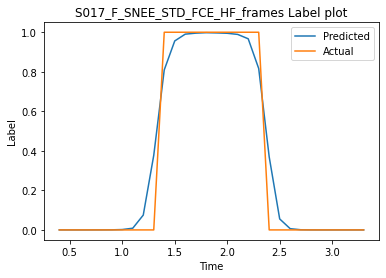

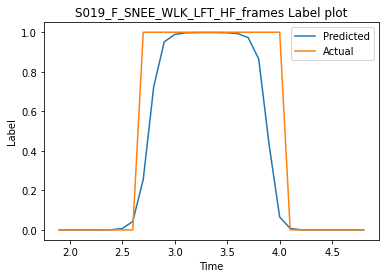

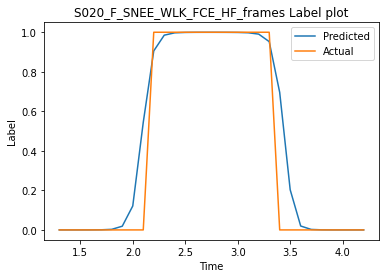

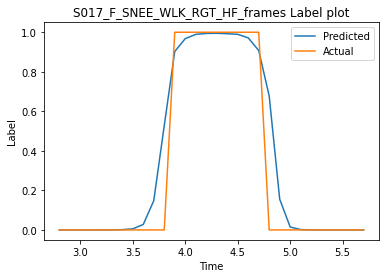

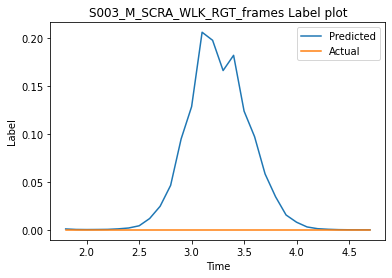

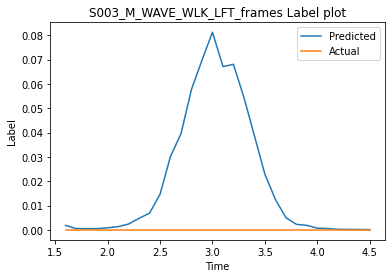

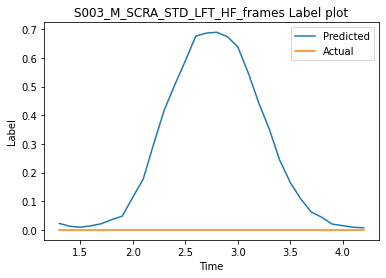

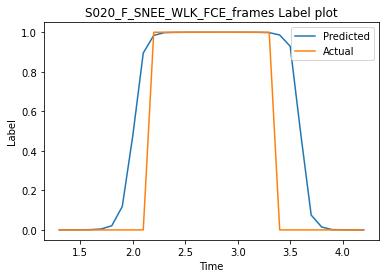

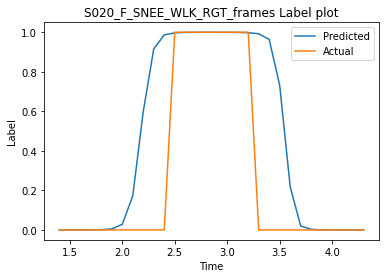

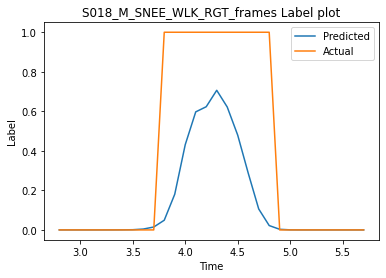

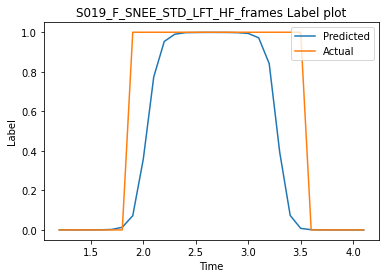

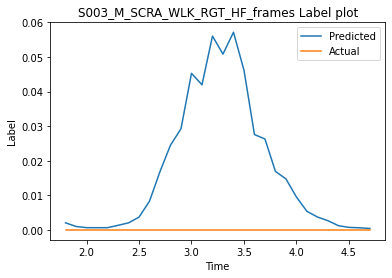

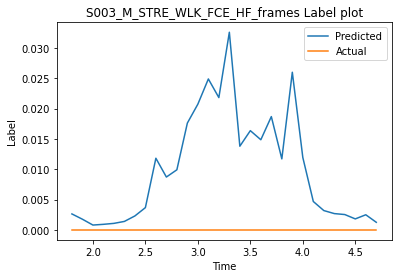

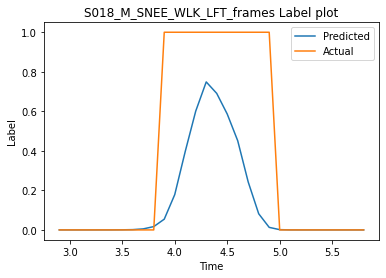

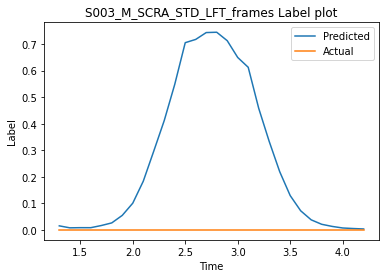

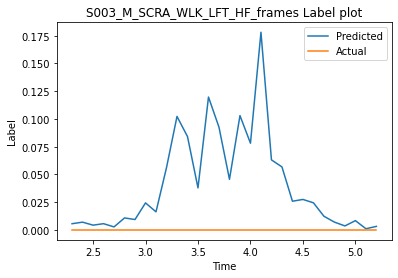

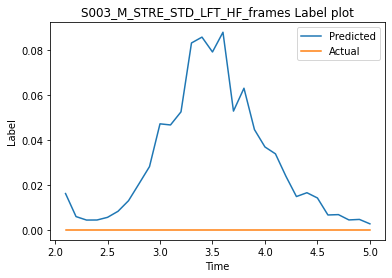

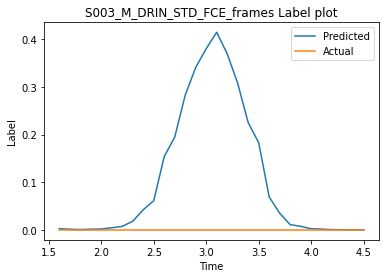

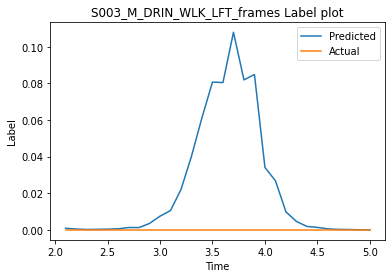

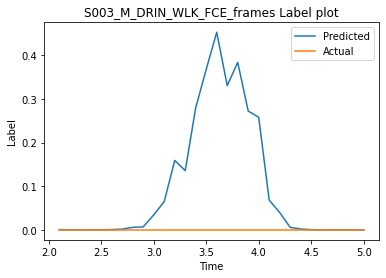

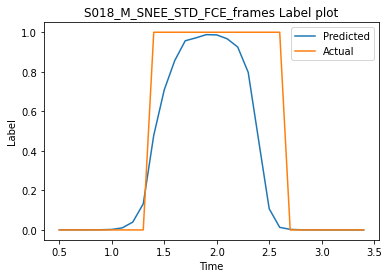

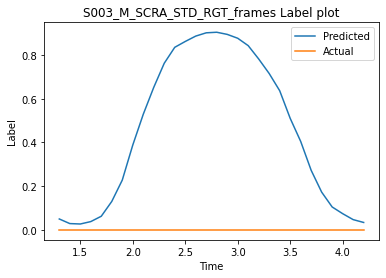

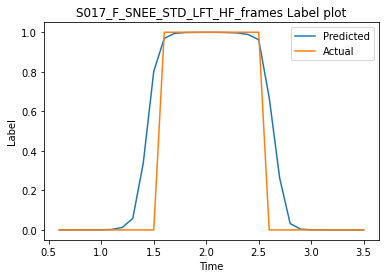

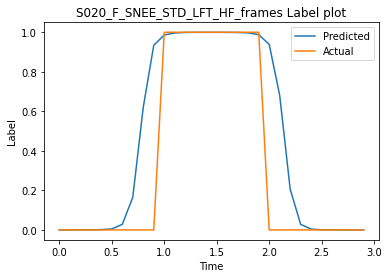

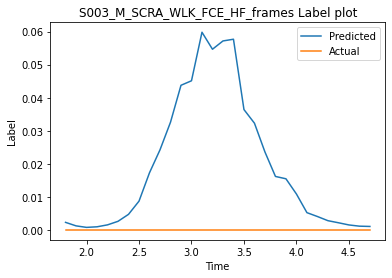

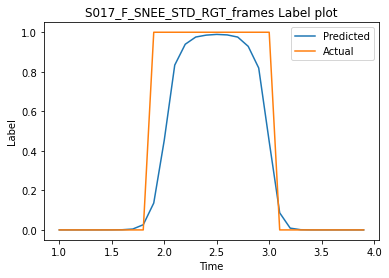

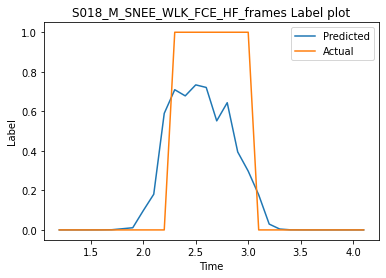

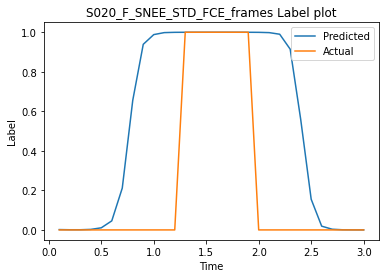

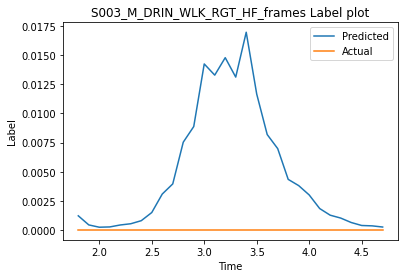

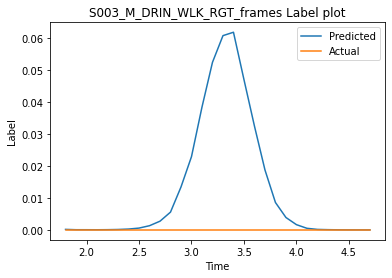

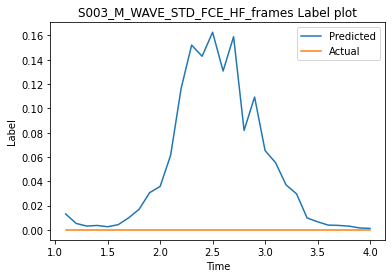

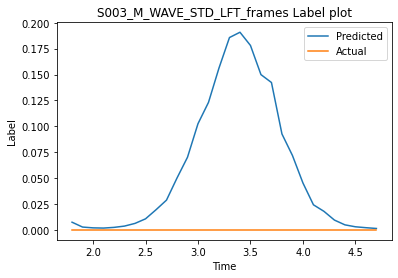

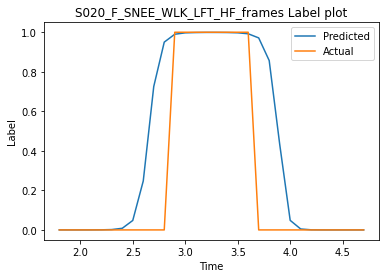

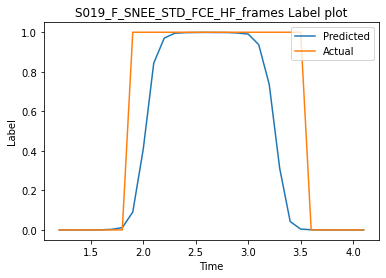

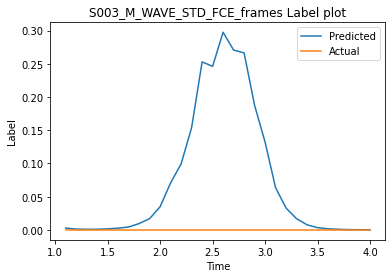

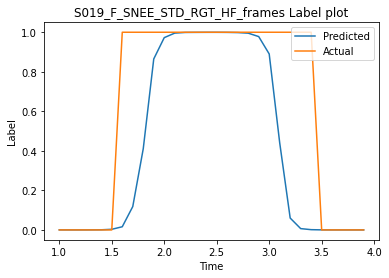

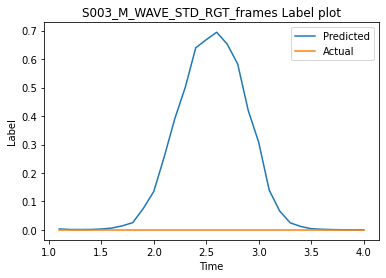

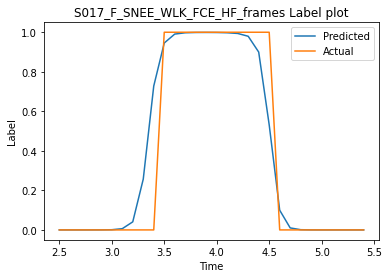

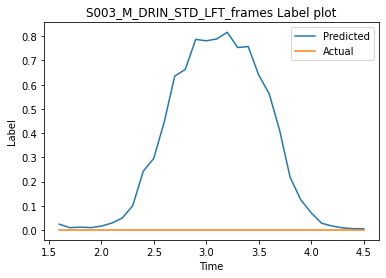

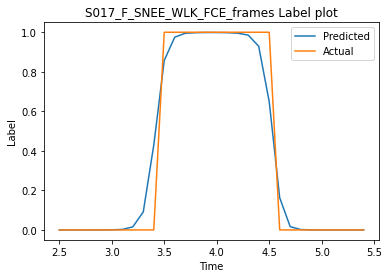

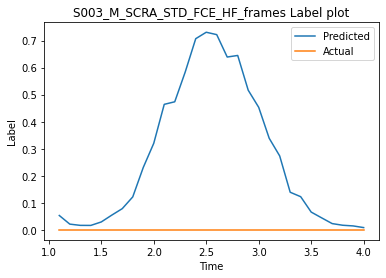

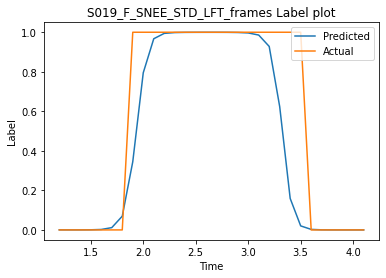

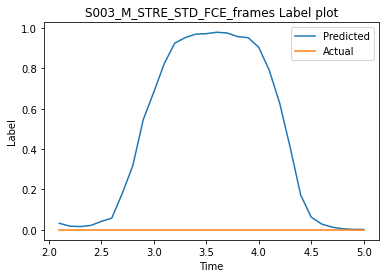

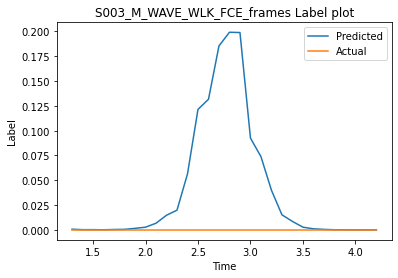

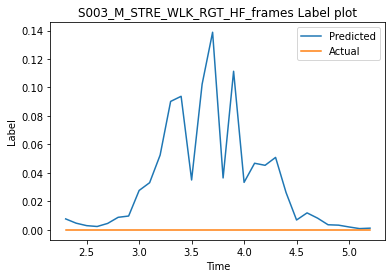

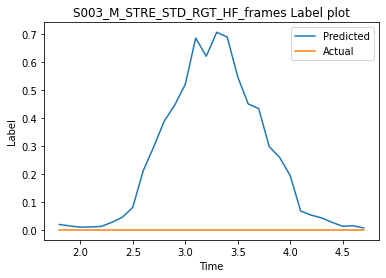

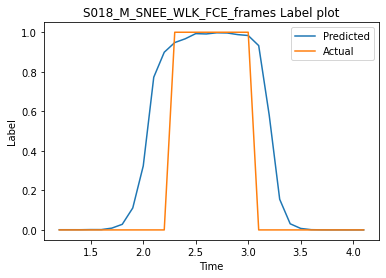

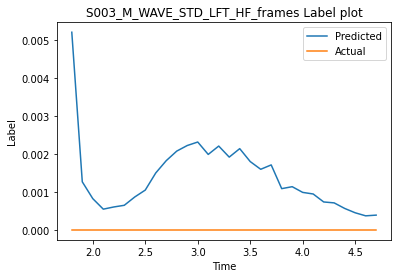

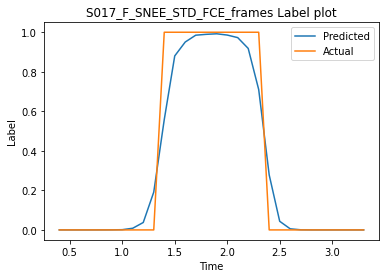

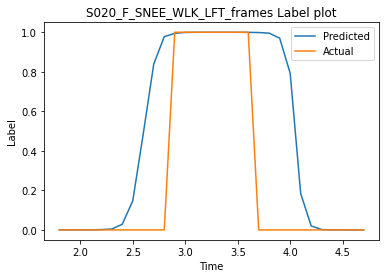

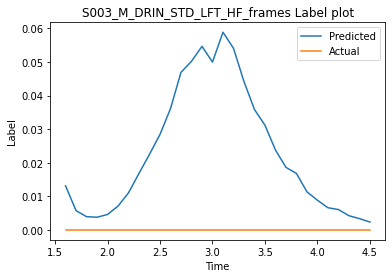

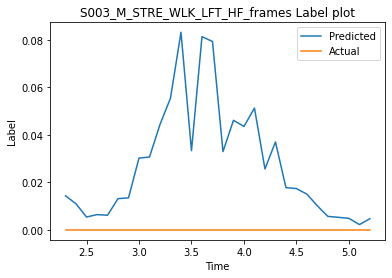

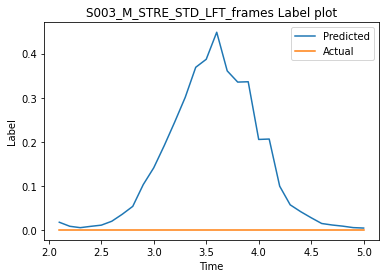

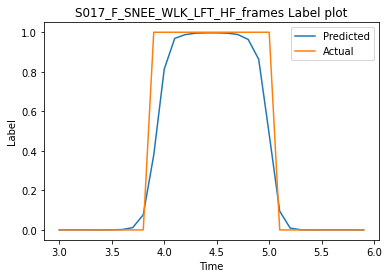

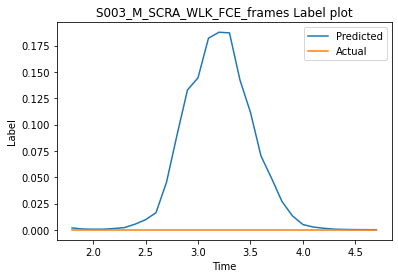

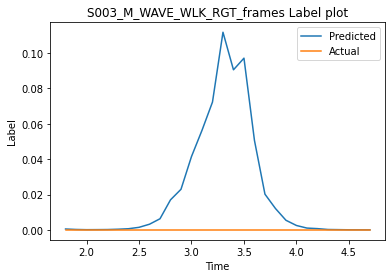

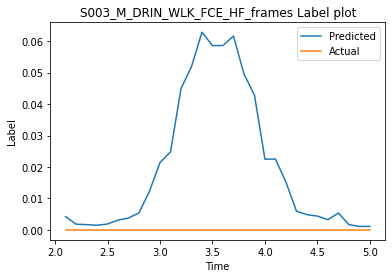

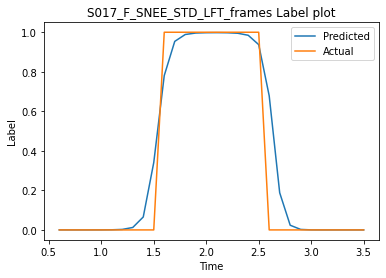

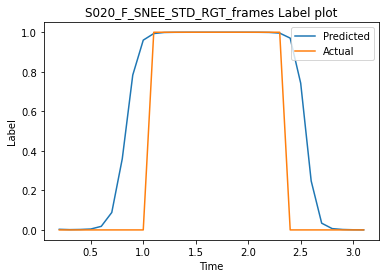

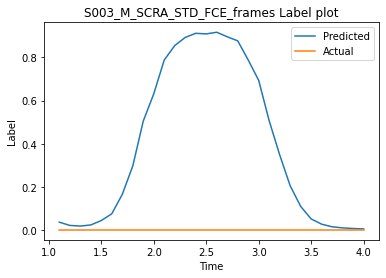

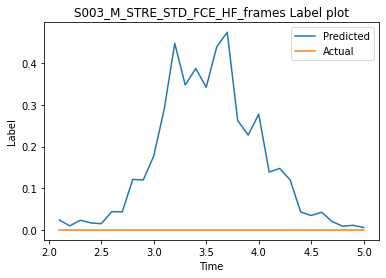

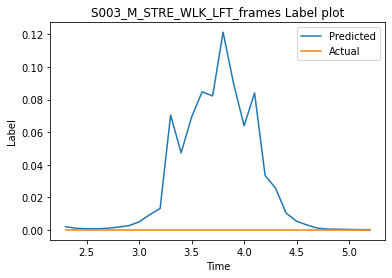

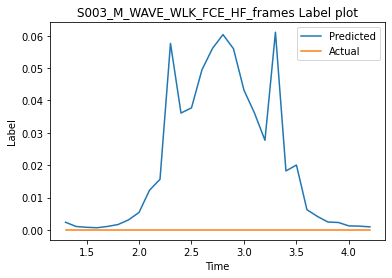

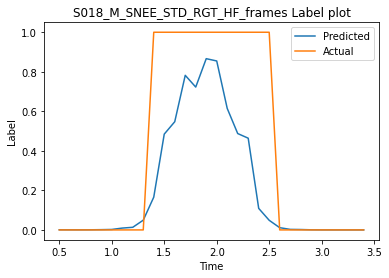

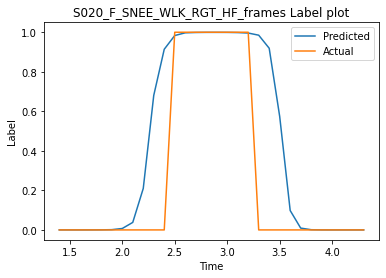

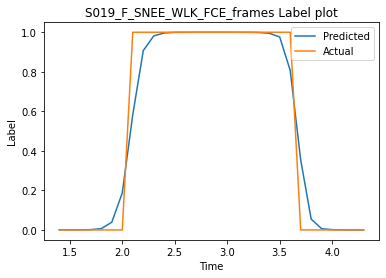

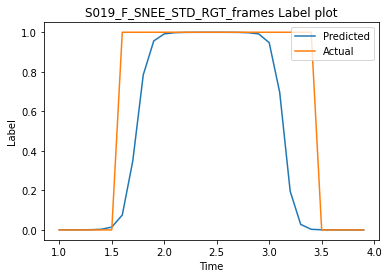

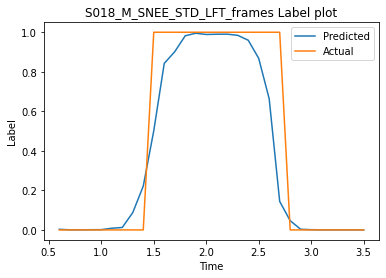

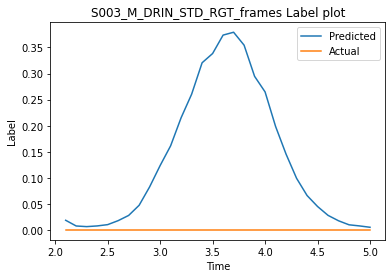

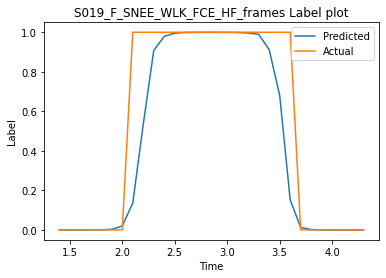

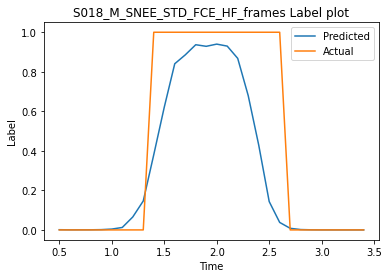

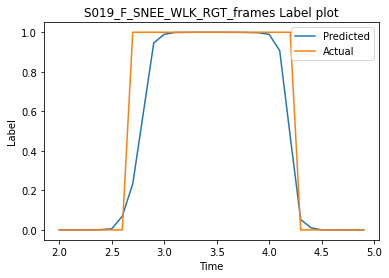

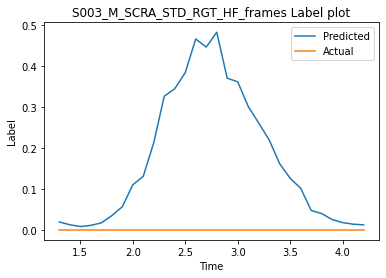

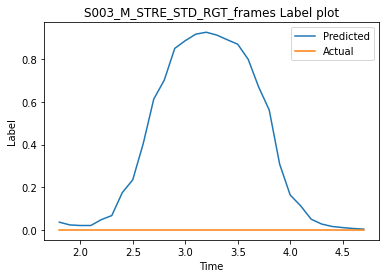

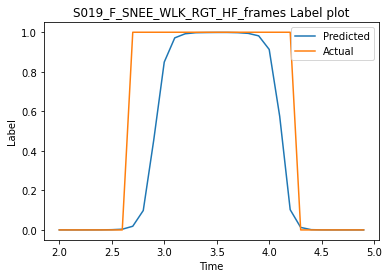

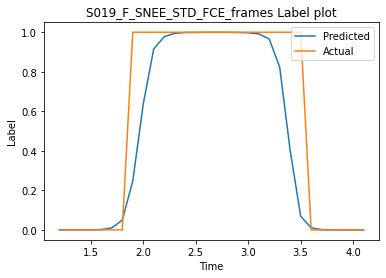

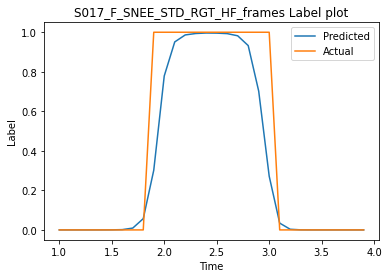

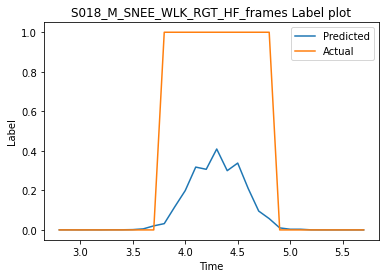

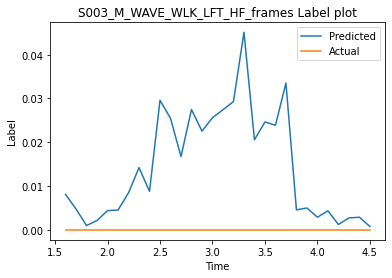

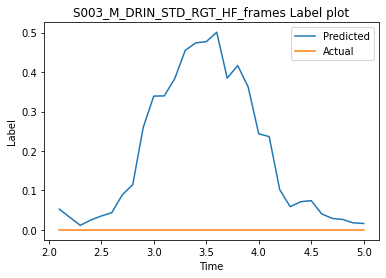

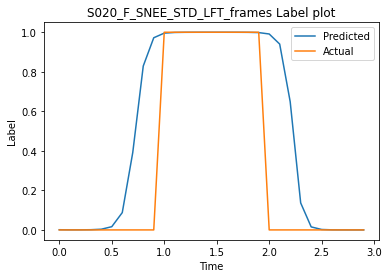

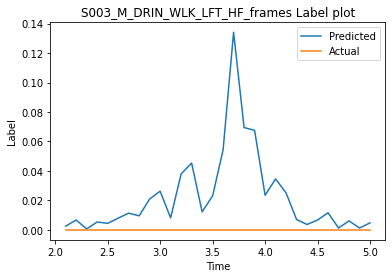

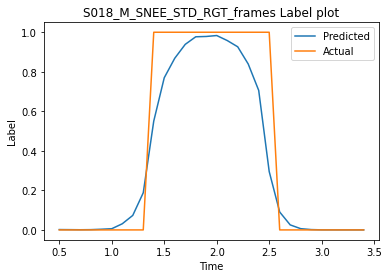

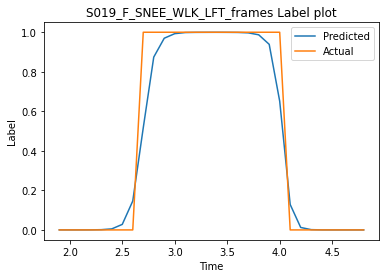

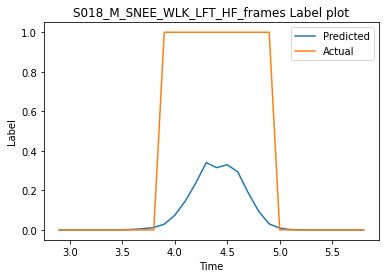

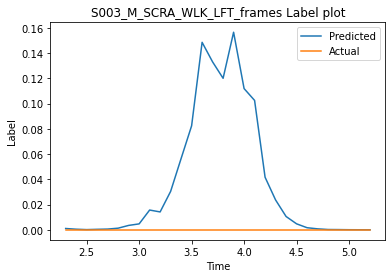

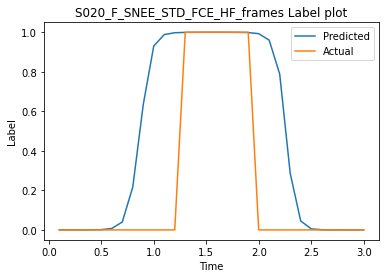

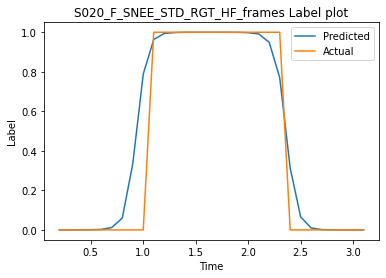

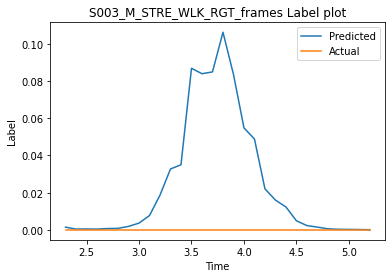

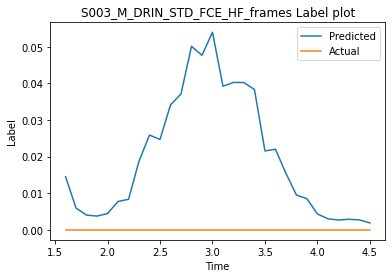

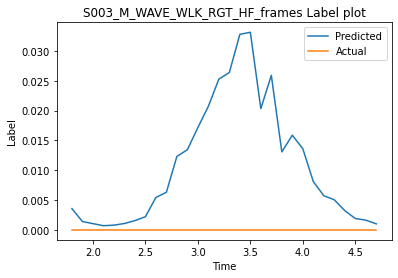

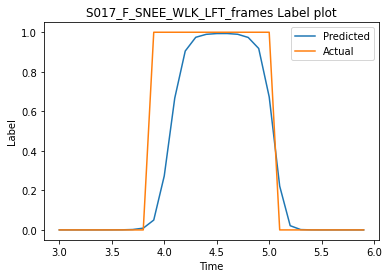

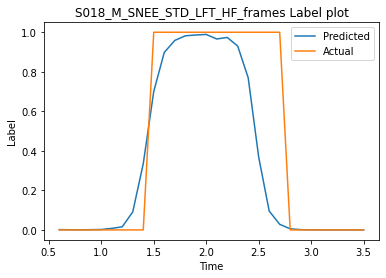

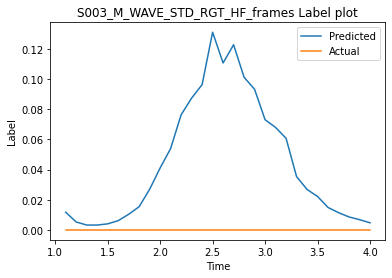

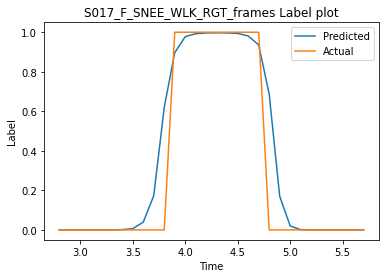

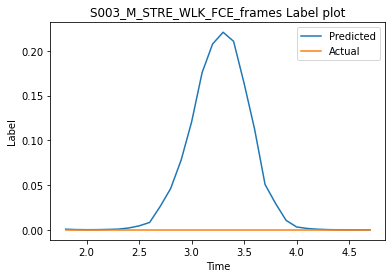

In [0]:
def get_times(y1,y2,vid,fps):
  frame_paths = os.listdir(test_path + vid)
  n_f = len(frame_paths)
  df = df2
  labels = y1
  where_are_nans = np.isnan(labels)
  labels[where_are_nans] = 0
  labels = np.squeeze(labels)
  n_l = len(y2)
  t1 = np.arange(len(y1))/fps
  if n_l > n_f :
    diff = math.ceil((n_l-n_f)/2)
    output = [None]*n_l
    t = [None]*n_l
    # Repeating First element
    output[0:diff] = [labels[0]]*diff
    t[0:diff] = [t1[0]]*diff
    # Centering frames
    output[diff:diff + n_f] = labels[0:n_f]
    t[diff:diff + n_f] = t1[0:n_f]
    #Repeating last frames
    output[diff + n_f:] = [labels[n_f]]*(n_l-n_f-diff)
    t[diff + n_f:] = [t1[n_f]]*(n_l-n_f-diff)
  elif n_l < n_f:
    if sum(labels)>0:
      where_are_ones = np.isin(labels,1)
      idxs = np.nonzero(where_are_ones)
      idxs = np.squeeze(idxs)
      l = labels[where_are_ones]
      diff = math.ceil((n_l - len(l))/2)
      d1 = idxs[0] - diff
      d2 = idxs[-1]+diff
      if d1<0:
        idx = [0,n_l]
        output = labels[idx[0]:idx[1]]
        t = t1[idx[0]:idx[1]]
      elif d2>n_f:
        #d1 = d1-d2+n_l
        idx = [n_f-n_l,n_f]
        output = labels[idx[0]:idx[1]]
        t = t1[idx[0]:idx[1]] 
      else:
        diff21 = math.floor((n_l - idxs[-1] + idxs[0])/2)
        diff22 = math.ceil((n_l - idxs[-1] + idxs[0])/2)
        diff23 = diff22-diff21
        idx = [idxs[0]-diff21,idxs[-1]+diff21+diff23]
        print('idx',idx)
        output = labels[idx[0]:idx[1]]
        t = t1[idx[0]:idx[1]]
        # print("D2-D1",d2-d1)
      print(labels[idx[0]:idx[1]])
    else:
      diff = math.ceil((n_f-n_l)/2)
      idx = [diff,diff+n_l]
      output = labels[idx[0]:idx[1]]
      t = t1[idx[0]:idx[1]]
  else:
    output = labels[0:n_l]
    t = t1[0:n_l]
  output = np.expand_dims(output,axis=1)
  output1 = 1 - output
  output2 = np.concatenate([output,output1],axis=1) 
  t = np.squeeze(np.array(t))
  return t,output


tl2 = []
y1_adj2 = list()
y_diff = list()
count = 0
for i,vid in enumerate(test_list):
  y1 = df2.loc[vid].values
  y2 = y_pred[i]
  t2,y1_adj = get_times(y1,y2,vid,10)
  y2x = y2[:,0]
  y1_adjx = y1_adj[:,0]
  plt.figure()
  plt.plot(t2,y2x)
  plt.plot(t2,y1_adjx)
  name = vid + ' Label plot' 
  plt.title(name)
  plt.ylabel('Label')
  plt.xlabel('Time')
  plt.legend(['Predicted', 'Actual'], loc='upper right')
  #plt.show()
  plt.savefig('drive/My Drive/Adv DL project/Label_figs3/'+vid+'.jpg')
  plt.close
  tl = []
  for j in range(len(y2)):
    tl.append([t2[j],y2x[j]])
  tl2.append(tl)
  y3 = np.zeros(y2x.shape)
  y3_adj = np.zeros(y1_adjx.shape)
  y3[y2x>=0.5] = 1
  y3_adj[y1_adjx>=0.5] = 1 
  y_diff += [np.sum(np.abs(y3-y3_adj))/len(y3)]
  y1_adj2 += [y3_adj]
  if list(y3)==list(y3_adj) :
    count +=1

In [0]:
d = {}
for i,vid in enumerate(test_list):
  d[vid] = tl2[i]
tL_df = pd.DataFrame(d)

In [0]:
names = ['S019_F_SNEE_STD_FCE_frames','S017_F_SNEE_STD_RGT_frames','S020_F_SNEE_WLK_RGT_frames','S003_M_WAVE_WLK_RGT_frames','S003_M_DRIN_STD_LFT_frames']
d2 = {}
for vid in d:
  for name in names:
    if name == vid:
      print(name)
      d2[name] = d[name]
tL_df2 = pd.DataFrame(d2)
tL_df2.to_json('drive/My Drive/Adv DL project/timeLabels_v2.json')

S020_F_SNEE_WLK_RGT_frames
S017_F_SNEE_STD_RGT_frames
S003_M_DRIN_STD_LFT_frames
S003_M_WAVE_WLK_RGT_frames
S019_F_SNEE_STD_FCE_frames


In [0]:
for name in names:
  tl_s = d2[name]
  tl_s = np.array(tl_s)
  fm_s = tl_s[:,0]*10
  print(name)
  print(fm_s) 

S019_F_SNEE_STD_FCE_frames
[12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41.]
S017_F_SNEE_STD_RGT_frames
[10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.
 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39.]
S020_F_SNEE_WLK_RGT_frames
[14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.
 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43.]
S003_M_WAVE_WLK_RGT_frames
[18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]
S003_M_DRIN_STD_LFT_frames
[16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.
 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.]


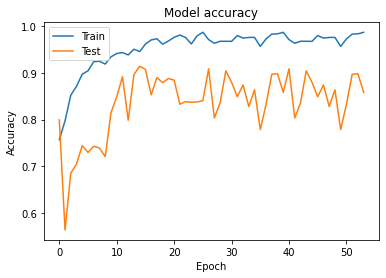

In [0]:
# Plot training & validation accuracy values
plt.plot(train_acc)
plt.plot(valid_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig('drive/My Drive/Adv DL project/Acc_vs_Epochs3.jpg')
# Plot training & validation loss values

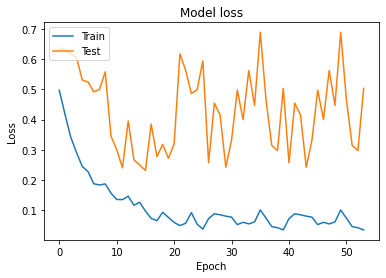

In [0]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig('drive/My Drive/Adv DL project/Loss_vs_Epochs3.jpg')